In [43]:
# run initial imports
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from fbprophet import Prophet

from ipywidgets import widgets

from datetime import datetime

In [31]:
NOW = datetime.now()

In [32]:
#setup initial data frames
covid_19_ts = pd.read_csv('./covid_19_ts.csv')
covid_19_national_observations = pd.read_csv('./covid_19_national_observations.csv')
covid_19_infected_observations = pd.read_csv('./covid_19_infected_observations.csv')
covid_19_world_totals = pd.read_csv('./covid_19_world_totals.csv')

In [33]:
#correct date parsing on some of the JH data
covid_19_ts['Date'] = pd.to_datetime(covid_19_ts['Date'])
covid_19_national_observations['Date'] = pd.to_datetime(covid_19_national_observations['Date'])
covid_19_infected_observations['Date'] = pd.to_datetime(covid_19_infected_observations['Date'])
covid_19_world_totals['Date'] = pd.to_datetime(covid_19_world_totals['Date'])

In [34]:
#quick national overview

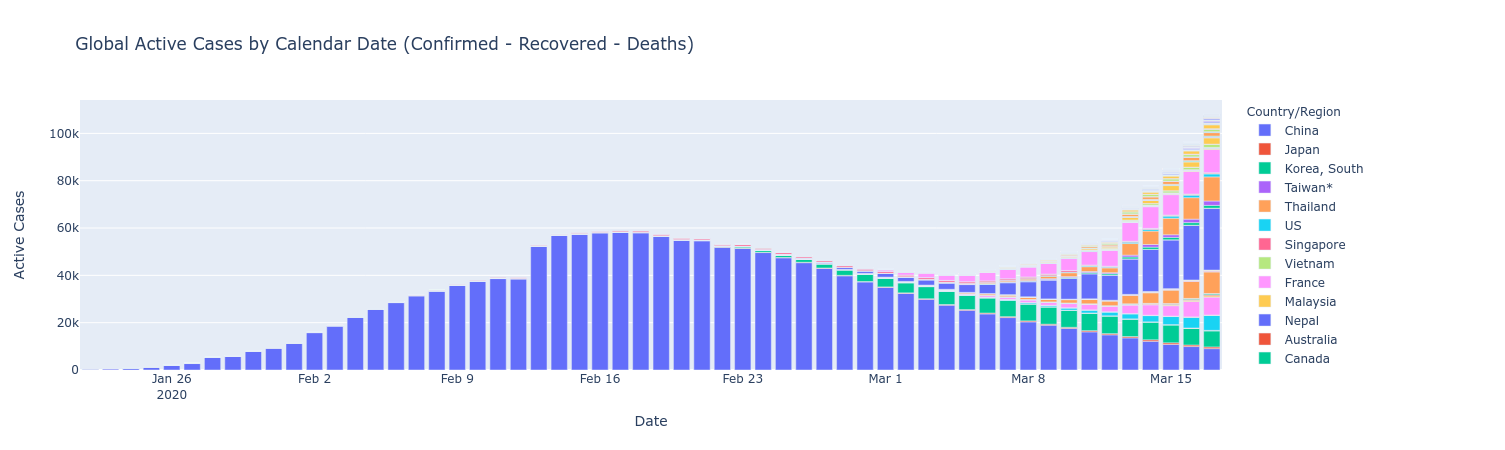

In [35]:
world_chart = px.bar(covid_19_national_observations, 
    x="Date", y="Active Cases", color="Country/Region", title="Global Active Cases by Calendar Date (Confirmed - Recovered - Deaths)")
world_chart.show()

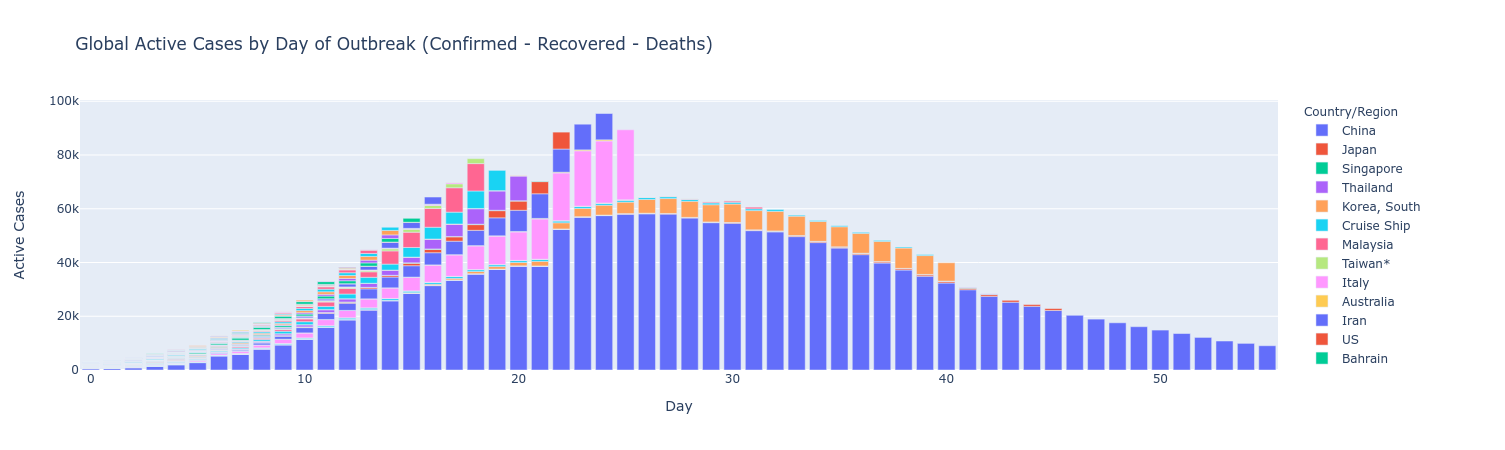

In [36]:
world_chart = px.bar(covid_19_infected_observations, 
    x="Day", y="Active Cases", color="Country/Region", title="Global Active Cases by Day of Outbreak (Confirmed - Recovered - Deaths)")
world_chart.show()

In [37]:
cn_df = covid_19_national_observations.copy()
cn_df = cn_df[cn_df['Country/Region'] == 'China']

In [38]:
cn_df['Death'].max() / (cn_df['Active Cases'].max() * 1.14) 

0.048759780638351576

In [39]:
countries = covid_19_national_observations.groupby('Country/Region')

In [40]:
#select a single from group
#countries.get_group('China')

/home/mprorock/devel/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=1.00752e-18): result may not be accurate.



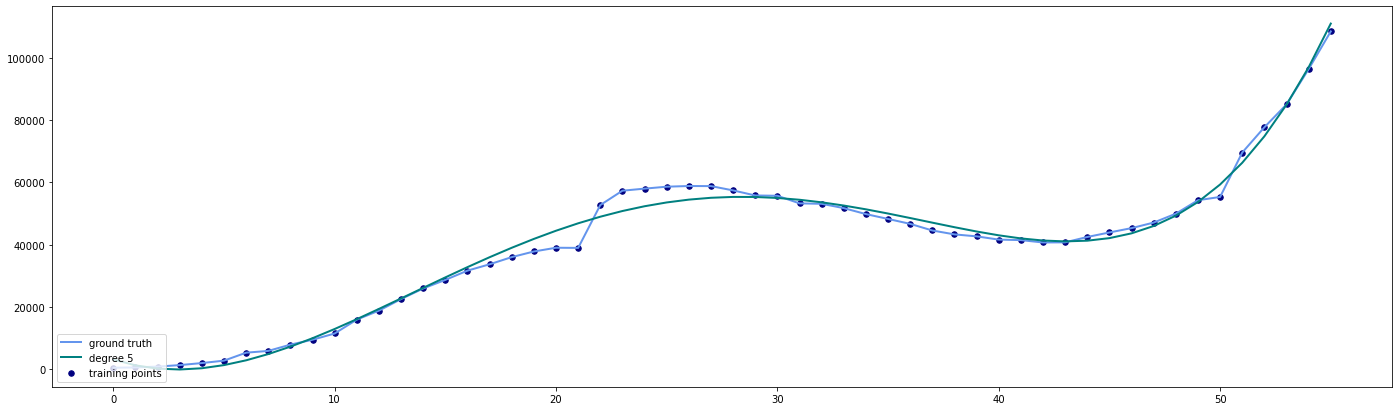

In [50]:
fDay=3

covid_19_world_totals=covid_19_world_totals.sort_values('Date')
covid_19_world_totals=covid_19_world_totals.reset_index(drop=True)
covid_19_world_totals['Day'] = covid_19_world_totals.index
x=covid_19_world_totals.index
y=covid_19_world_totals['Active Cases']

x_plot = x

# create matrix versions of these arrays
X = x[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2

plt.figure(figsize=(24,7))
plt.plot(x, y, color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

In [52]:
fb_df = covid_19_world_totals[['Date', 'Active Cases']]
fb_df.columns = ['ds','y']

m = Prophet(daily_seasonality=True)
m.fit(fb_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
